In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('diabetes.csv')
df_original = df.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Overview

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


 # Missing Value analysis

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

In [6]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [7]:
# The missing values will be filled with the median values of each variable.

def median_target(var):   
    
    temp = df[df[var].notnull()]
    
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    
    return temp

In [8]:
# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.

columns = df.columns

columns = columns.drop("Outcome")

for col in columns:
    
    df.loc[(df['Outcome'] == 0 ) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1 ) & (df[col].isnull()), col] = median_target(col)[col][1]

In [9]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


# Outlier analysis

In [10]:
Q1 = df["BloodPressure"].quantile(0.25)
Q3 = df["BloodPressure"].quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

In [11]:
upper

104.0

In [12]:
lower

40.0

In [13]:
for feature in df:
    print(feature)

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age
Outcome


In [14]:
# Checking if there are outliers
for feature in df:
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies yes
Glucose no
BloodPressure yes
SkinThickness yes
Insulin yes
BMI yes
DiabetesPedigreeFunction yes
Age yes
Outcome no


In [15]:
# Checking if there are extreme outliers
for feature in df:
    
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] > upper)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure no
SkinThickness yes
Insulin yes
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [16]:
# Checking if there are outliers
for feature in df:
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] < lower)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure yes
SkinThickness yes
Insulin no
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [17]:
# Checking if there are extreme outliers
for feature in df:
    
    Q1 = df[feature].quantile(0.05)
    Q3 = df[feature].quantile(0.95)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    if df[(df[feature] < lower)].any(axis=None):
        print(feature,"yes")
    else:
        print(feature, "no")

Pregnancies no
Glucose no
BloodPressure no
SkinThickness no
Insulin no
BMI no
DiabetesPedigreeFunction no
Age no
Outcome no


In [18]:
# The extreme outliers will be replaced with median values

In [19]:
# Calculate the median values for 'SkinThickness' and 'Insulin'
median_skinthickness = df['SkinThickness'].median()
median_insulin = df['Insulin'].median()

# Define the upper threshold for extreme outliers
Q1_skin = df['SkinThickness'].quantile(0.05)
Q3_skin = df['SkinThickness'].quantile(0.95)
IQR_skin = Q3_skin - Q1_skin
upper_skin = Q3_skin + 1.5 * IQR_skin

Q1_insulin = df['Insulin'].quantile(0.05)
Q3_insulin = df['Insulin'].quantile(0.95)
IQR_insulin = Q3_insulin - Q1_insulin
upper_insulin = Q3_insulin + 1.5 * IQR_insulin

# Replace extreme outliers with the median values
df.loc[df['SkinThickness'] > upper_skin, 'SkinThickness'] = median_skinthickness
df.loc[df['Insulin'] > upper_insulin, 'Insulin'] = median_insulin


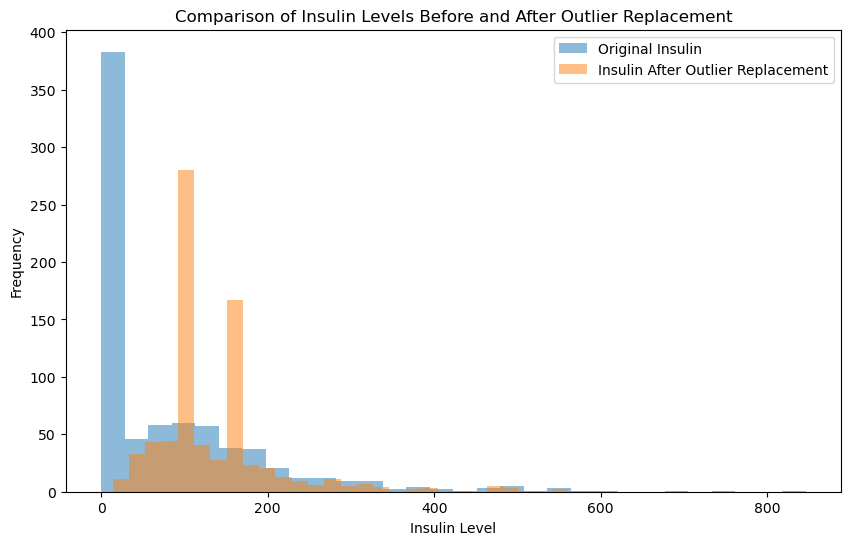

In [20]:
plt.figure(figsize=(10, 6))

# Plot histogram for original Insulin data
plt.hist(df_original['Insulin'].dropna(), bins=30, alpha=0.5, label='Original Insulin')

# Plot histogram for Insulin data after replacing outliers
plt.hist(df['Insulin'].dropna(), bins=30, alpha=0.5, label='Insulin After Outlier Replacement')

plt.title('Comparison of Insulin Levels Before and After Outlier Replacement')
plt.xlabel('Insulin Level')
plt.ylabel('Frequency')
plt.legend()

plt.show()

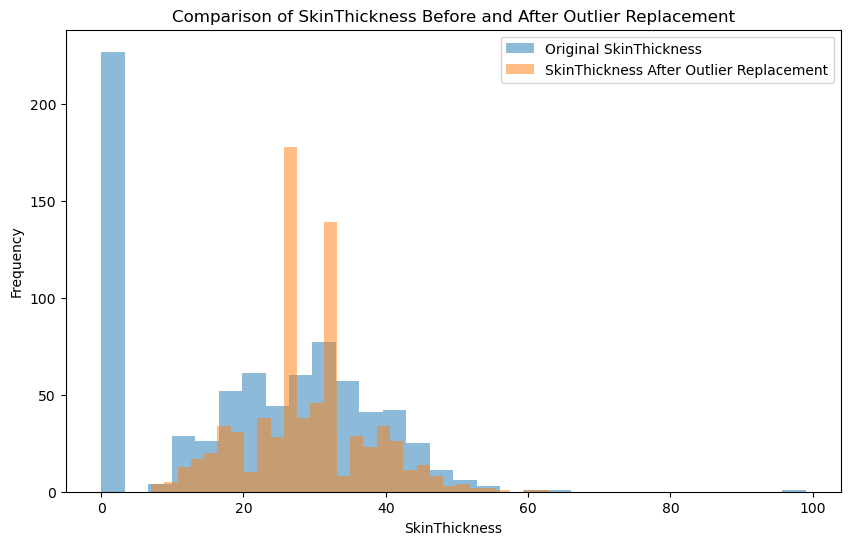

In [21]:
plt.figure(figsize=(10, 6))

# Plot histogram for original SkinThickness data
plt.hist(df_original['SkinThickness'].dropna(), bins=30, alpha=0.5, label='Original SkinThickness')

# Plot histogram for SkinThickness data after replacing outliers
plt.hist(df['SkinThickness'].dropna(), bins=30, alpha=0.5, label='SkinThickness After Outlier Replacement')

plt.title('Comparison of SkinThickness Before and After Outlier Replacement')
plt.xlabel('SkinThickness')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [22]:
# It is visible that the original dataframe consists of many 0's and also has values greater than 600, 
# while the modified dataset doesn't have 0s and no values greater than approximately 600

In [23]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [24]:
df.to_csv('diabetes_modified.csv', index=False)

In [25]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis = 1)

cols = X.columns
index = X.index

In [26]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [27]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [28]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [29]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.765432,0.000,1.000000,1.000000,0.170330,0.665359,1.235294
1,-0.4,-0.790123,-0.375,0.142857,0.000000,-0.598901,-0.056209,0.117647
2,1.0,1.629630,-0.500,0.571429,1.000000,-0.961538,0.783007,0.176471
3,-0.4,-0.691358,-0.375,-0.714286,-0.126866,-0.434066,-0.537255,-0.470588
4,-0.6,0.493827,-2.000,1.000000,0.977612,1.214286,5.007843,0.235294


# Model

LR: 0.777341 (0.029313)
LR:
Mean Accuracy: 0.7773 (Std: 0.0293)
ROC-AUC: 0.7355
Confusion Matrix:
 [[437  63]
 [108 160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84       500
           1       0.72      0.60      0.65       268

    accuracy                           0.78       768
   macro avg       0.76      0.74      0.74       768
weighted avg       0.77      0.78      0.77       768

KNN: 0.858100 (0.024125)
KNN:
Mean Accuracy: 0.8581 (Std: 0.0241)
ROC-AUC: 0.8408
Confusion Matrix:
 [[449  51]
 [ 58 210]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89       500
           1       0.80      0.78      0.79       268

    accuracy                           0.86       768
   macro avg       0.85      0.84      0.84       768
weighted avg       0.86      0.86      0.86       768

CART: 0.852905 (0.025130)
CART:
Mean Accuracy: 0.852

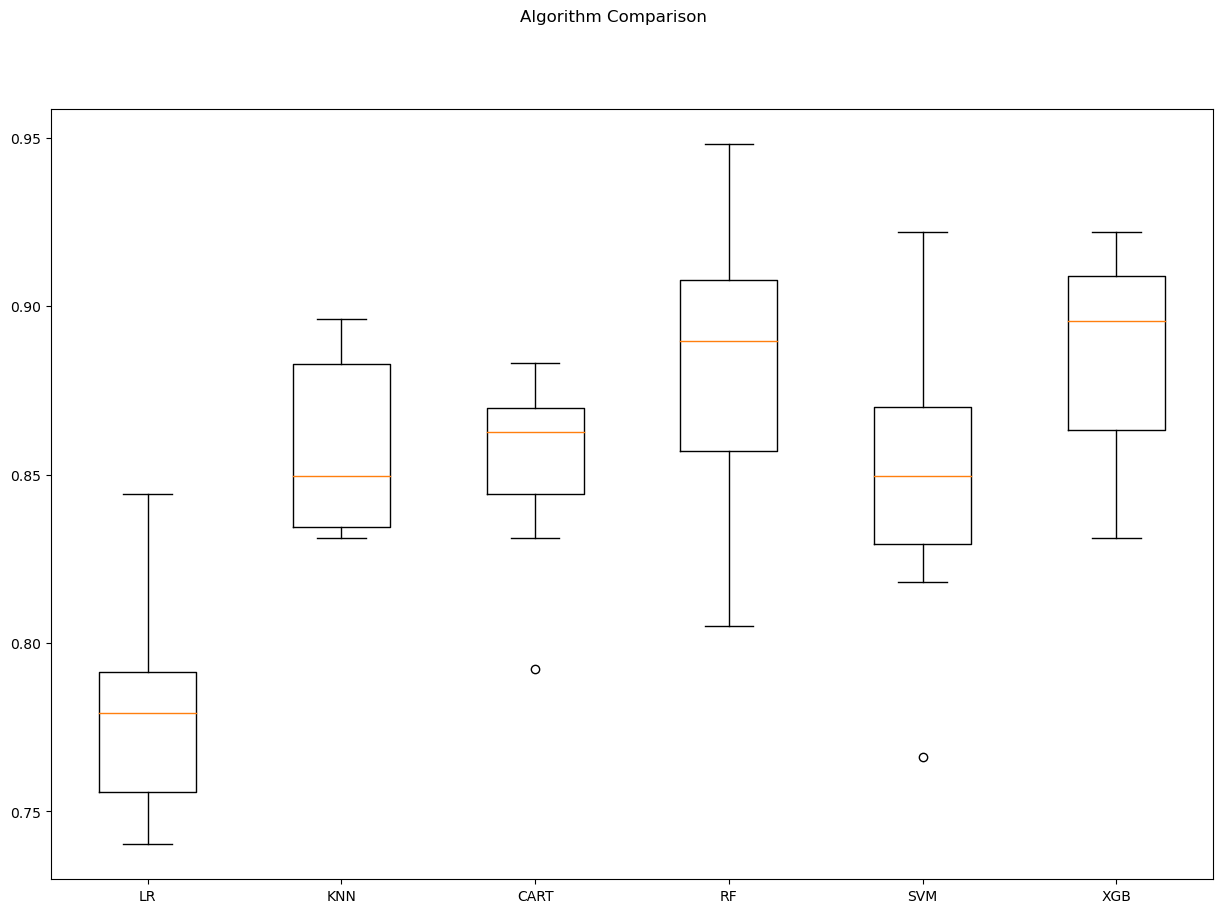

In [30]:
models = []
models = [
    ('LR', LogisticRegression(random_state=12345)),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier(random_state=12345)),
    ('RF', RandomForestClassifier(random_state=12345)),
    ('SVM', SVC(gamma='auto', random_state=12345, probability=True)),  # Enable probability for ROC-AUC
    ('XGB', GradientBoostingClassifier(random_state=12345))
]

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    y_pred = cross_val_predict(model, X, y, cv=kfold)  # Get predictions for each fold
    roc_auc = roc_auc_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    results.append(cv_results)
    names.append(name)

    print(f"{name}:")
    print(f"Mean Accuracy: {cv_results.mean():.4f} (Std: {cv_results.std():.4f})")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

# Boxplot for algorithm comparison
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Analysis

Logistic Regression (LR):
Mean Accuracy: 0.7773
ROC-AUC: 0.7355
Precision: 0.72 for class 1
Recall: 0.60 for class 1
Analysis: LR shows moderate accuracy and ROC-AUC. Its precision and recall for the positive class (diabetes) indicate it's better at predicting non-diabetic cases correctly but has room for improvement in identifying diabetic cases.

K-Nearest Neighbors (KNN):
Mean Accuracy: 0.8581
ROC-AUC: 0.8408
Precision: 0.80 for class 1
Recall: 0.78 for class 1
Analysis: KNN performs better than LR with higher accuracy and ROC-AUC. It shows good balance in precision and recall, indicating it's relatively reliable in identifying both classes.

Decision Tree (CART):
Mean Accuracy: 0.8529
ROC-AUC: 0.8394
Precision: 0.79 for class 1
Recall: 0.79 for class 1
Analysis: CART demonstrates good accuracy and ROC-AUC, similar to KNN. It maintains a balance between precision and recall, suggesting it can identify diabetic and non-diabetic cases with reasonable accuracy.

Random Forest (RF):
Mean Accuracy: 0.8816
ROC-AUC: 0.8649
Precision: 0.84 for class 1
Recall: 0.81 for class 1
Analysis: RF shows the best performance among the evaluated models in terms of accuracy and ROC-AUC. It has high precision and recall for the positive class, indicating it's effective in both identifying true diabetic cases and avoiding false positives.

Support Vector Machine (SVM):
Mean Accuracy: 0.8489
ROC-AUC: 0.8329
Precision: 0.79 for class 1
Recall: 0.78 for class 1
Analysis: SVM provides good accuracy and ROC-AUC, with balanced precision and recall. It's effective but slightly less so than RF and KNN in this dataset.

Gradient Boosting (XGB):
Mean Accuracy: 0.8880
ROC-AUC: 0.8724
Precision: 0.85 for class 1
Recall: 0.82 for class 1
Analysis: XGB offers the highest accuracy and ROC-AUC among all models. It also shows high precision and recall, indicating its strong performance in identifying both diabetic and non-diabetic cases correctly.

# Analysis

Random Forest and Gradient Boosting are the top performers, indicating that ensemble methods are well-suited for this dataset, thus they are selected for tuning
Precision and Recall: Higher values in these metrics for class 1 are desirable as they indicate the model's effectiveness in correctly identifying diabetic cases (true positives) and minimizing false positives.
ROC-AUC: Higher values suggest better model performance in distinguishing between the classes under various threshold settings.

# Tuning models using GridSearchCV

In [31]:
# Random Forest
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}

rf_model = RandomForestClassifier(random_state = 12345)

gs_cv = GridSearchCV(rf_model, 
                    rf_params,
                    cv = 10,
                    n_jobs = -1,
                    verbose = 2).fit(X, y)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [32]:
gs_cv.best_params_

{'max_depth': 5,
 'max_features': 7,
 'min_samples_split': 10,
 'n_estimators': 100}

In [33]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)

In [34]:
rf_tuned = rf_tuned.fit(X,y)

In [35]:
cross_val_score(rf_tuned, X, y, cv = 10).mean()

0.8841421736158578

In [36]:
xgb = GradientBoostingClassifier(random_state = 12345)

In [37]:
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,1000]}

In [38]:
xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X, y)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=500; total time=   0.4s
[CV] END max_depth=3, max_features=3, min_samples_split=2, n_estimators=1000; total time=   0.8s
[CV] END max_depth=3, max_features=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=3, max_features=3, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END max_depth=3, max_features=3, min_samples_split=5, n_estimators=500; total time=   0.4s
[CV] END max_depth=3, max_features=3, min_samples_split=5, n_estimators=1000; total time=   0.8s
[CV] END max_depth=3, max_features=3, min_samples_split=10, n_estimat

In [42]:
xgb_cv_model.best_params_

{'learning_rate': 0.01,
 'max_depth': 8,
 'min_samples_split': 0.32222222222222224,
 'n_estimators': 1000,
 'subsample': 0.9}

In [43]:
xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_).fit(X,y)

In [44]:
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

0.886790840738209

# Comparison

In [45]:
models = []

models.append(('RF', RandomForestClassifier(random_state = 12345, max_depth = 5, max_features = 7, min_samples_split = 10, n_estimators = 100)))
models.append(('XGB', GradientBoostingClassifier(random_state = 12345, learning_rate = 0.01, max_depth = 8, min_samples_split = 0.322222, n_estimators = 1000, subsample = 0.9)))

results = []
names = []

RF: 0.894566 (0.028071)
XGB: 0.895899 (0.017120)


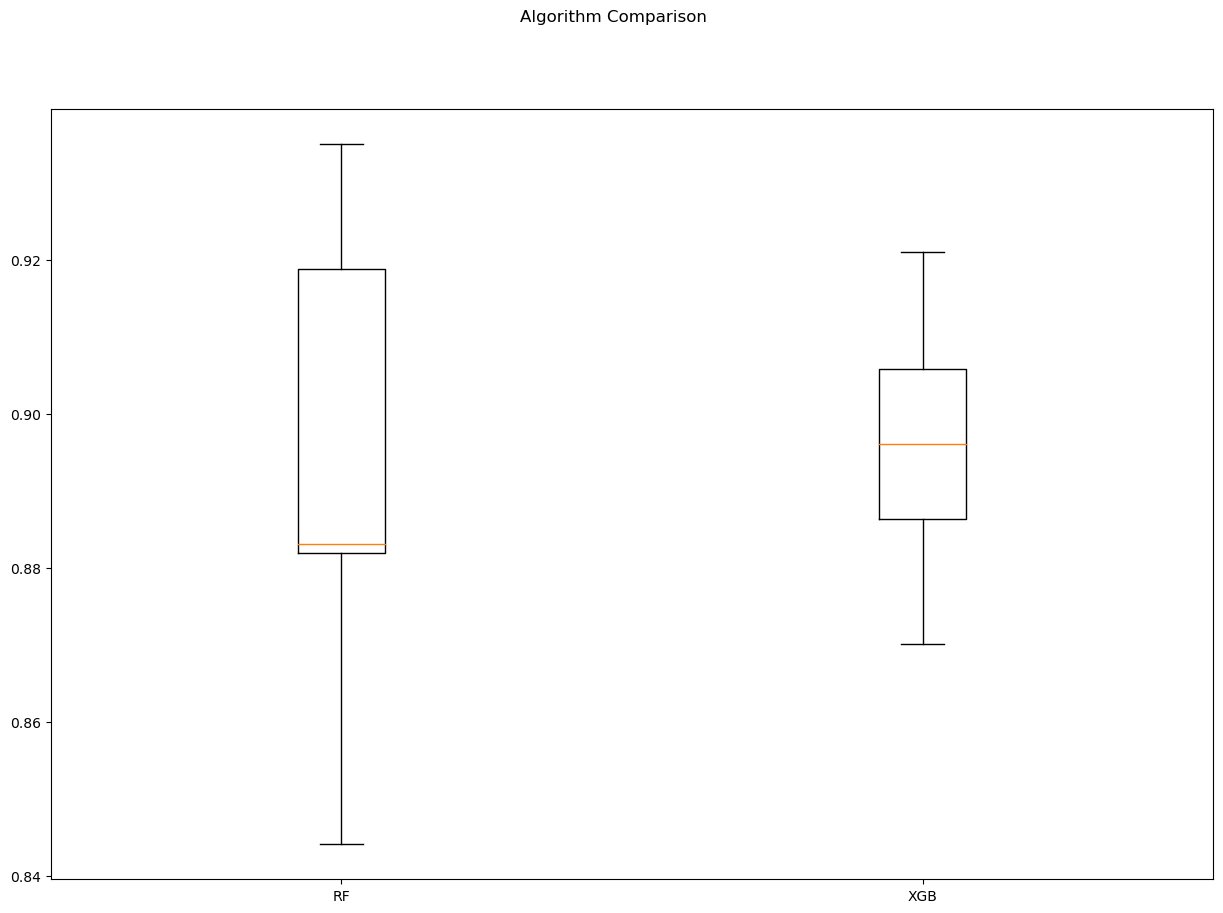

In [46]:
for name, model in models:
    
        kfold = KFold(n_splits = 10)
        cv_results = cross_val_score(model, X, y, cv = 10, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [47]:
# Columns for which you want to find the max and min values
columns = ['DiabetesPedigreeFunction', 'BMI', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure', 'Age', 'Pregnancies']

# Initialize dictionaries to store the max and min values
max_values = {}
min_values = {}

# Iterate over the columns and compute max and min for each
for col in columns:
    max_values[col] = df[col].max()
    min_values[col] = df[col].min()

# Display the results
print("Maximum Values:")
for col, max_val in max_values.items():
    print(f"{col}: {max_val}")

print("\nMinimum Values:")
for col, min_val in min_values.items():
    print(f"{col}: {min_val}")


Maximum Values:
DiabetesPedigreeFunction: 2.42
BMI: 67.1
SkinThickness: 63.0
Insulin: 600.0
Glucose: 199.0
BloodPressure: 122.0
Age: 81
Pregnancies: 17

Minimum Values:
DiabetesPedigreeFunction: 0.078
BMI: 18.2
SkinThickness: 7.0
Insulin: 14.0
Glucose: 44.0
BloodPressure: 24.0
Age: 21
Pregnancies: 0
